# Example of usage Spark OCR for Tables Recognition

This notebook demonstrate end-to-end pipeline for extract tabular data from image-based documents.

For more details about table recognition please read: [Table Detection & Extraction in Spark OCR](https://medium.com/spark-nlp/table-detection-extraction-in-spark-ocr-50765c6cedc9)

## Install spark-ocr python packge

Need to specify:
- secret
- license
- aws credentials

In [1]:
secret = ""
license = ""
version = secret.split("-")[0]
spark_ocr_jar_path = "../../spark-ocr/target/scala-2.12/" #"../../target/scala-2.11/"
AWS_ACCESS_KEY_ID = ""
AWS_SECRET_ACCESS_KEY = ""

import os
os.environ['JSL_OCR_LICENSE'] = license
os.environ["AWS_ACCESS_KEY_ID"] = AWS_ACCESS_KEY_ID
os.environ["AWS_SECRET_ACCESS_KEY"] = AWS_SECRET_ACCESS_KEY
imagePath = "./data/tab_images_hocr/*.jpg"

In [2]:
#%%bash
#if python -c 'import google.colab' &> /dev/null; then
#    echo "Run on Google Colab!"
#    echo "Install Open JDK"
#    apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
#    java -version
#fi

In [3]:
# install from PYPI using secret
#%pip install spark-ocr==$version+spark30 --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade
#%pip install --upgrade spark-ocr==4.0.0+spark32 --user --extra-index-url https://pypi.johnsnowlabs.com/$secret --upgrade

## Initialization of spark session
Need specify path to `spark-ocr-assembly.jar` or `secret`

In [4]:
from pyspark import SparkConf
from sparkocr import start

spark = start(jar_path=spark_ocr_jar_path)

spark

Spark version: 3.2.2
Spark NLP version: 4.1.0
Spark NLP for Healthcare version: 4.1.0
Spark OCR version: 4.2.0



## Read images and display it


    Image #0:
    Origin: file:/home/alexander_jsl/Workspace/spark-ocr-workshop/jupyter/data/tab_images_hocr/cTDaR_t10168.jpg
    Resolution: 0 dpi
    Width: 1061 px
    Height: 1373 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


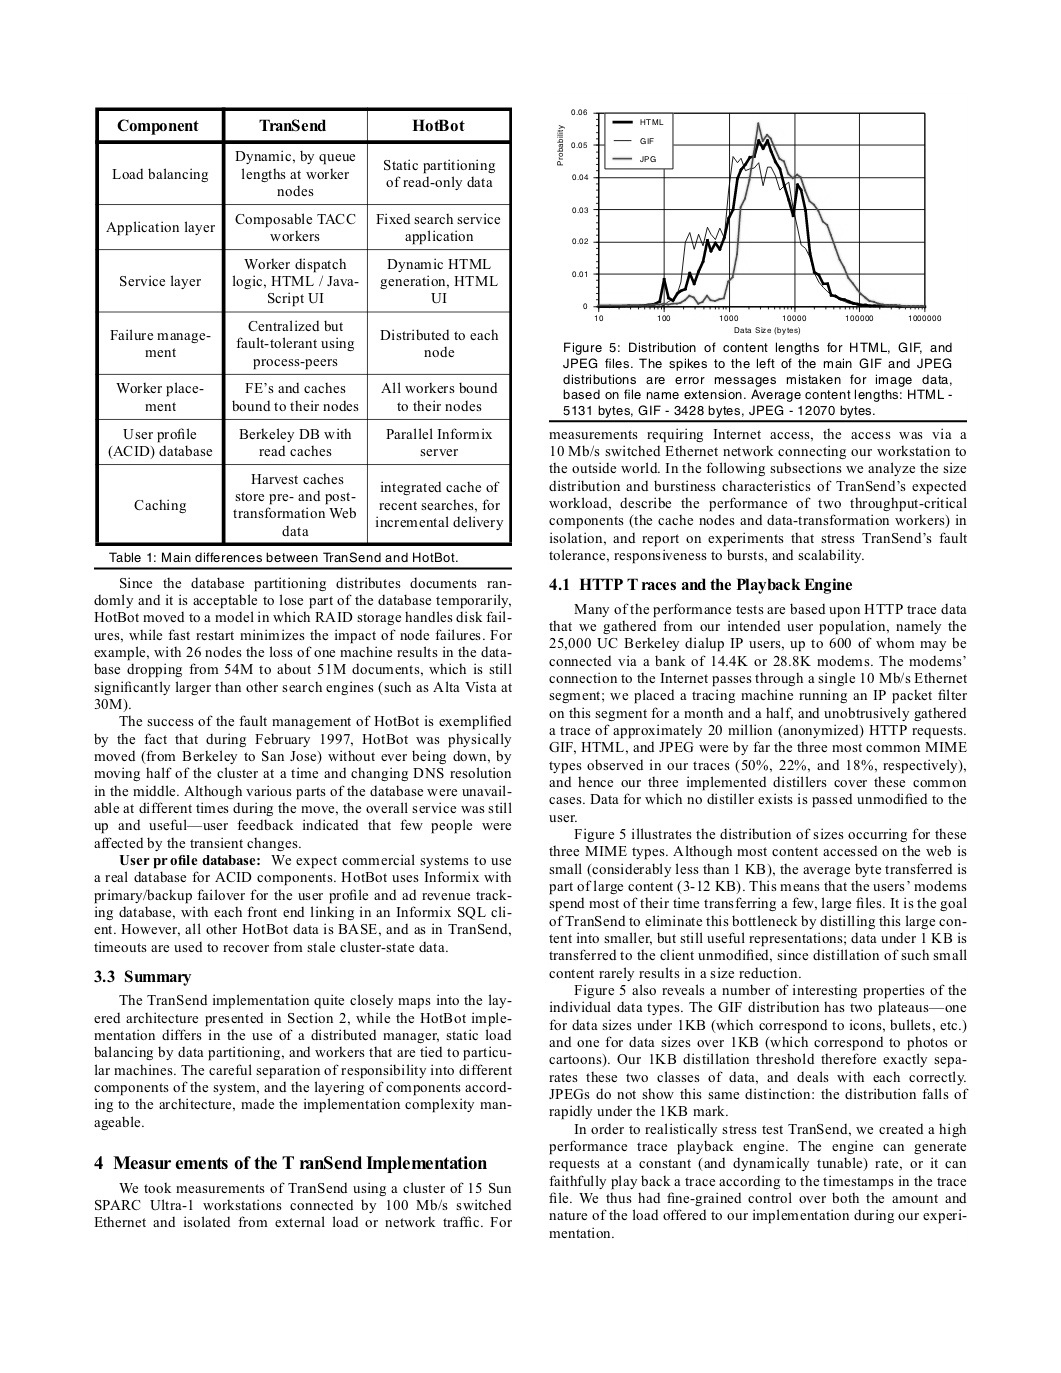


    Image #1:
    Origin: file:/home/alexander_jsl/Workspace/spark-ocr-workshop/jupyter/data/tab_images_hocr/table4.jpg
    Resolution: 0 dpi
    Width: 1471 px
    Height: 1654 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


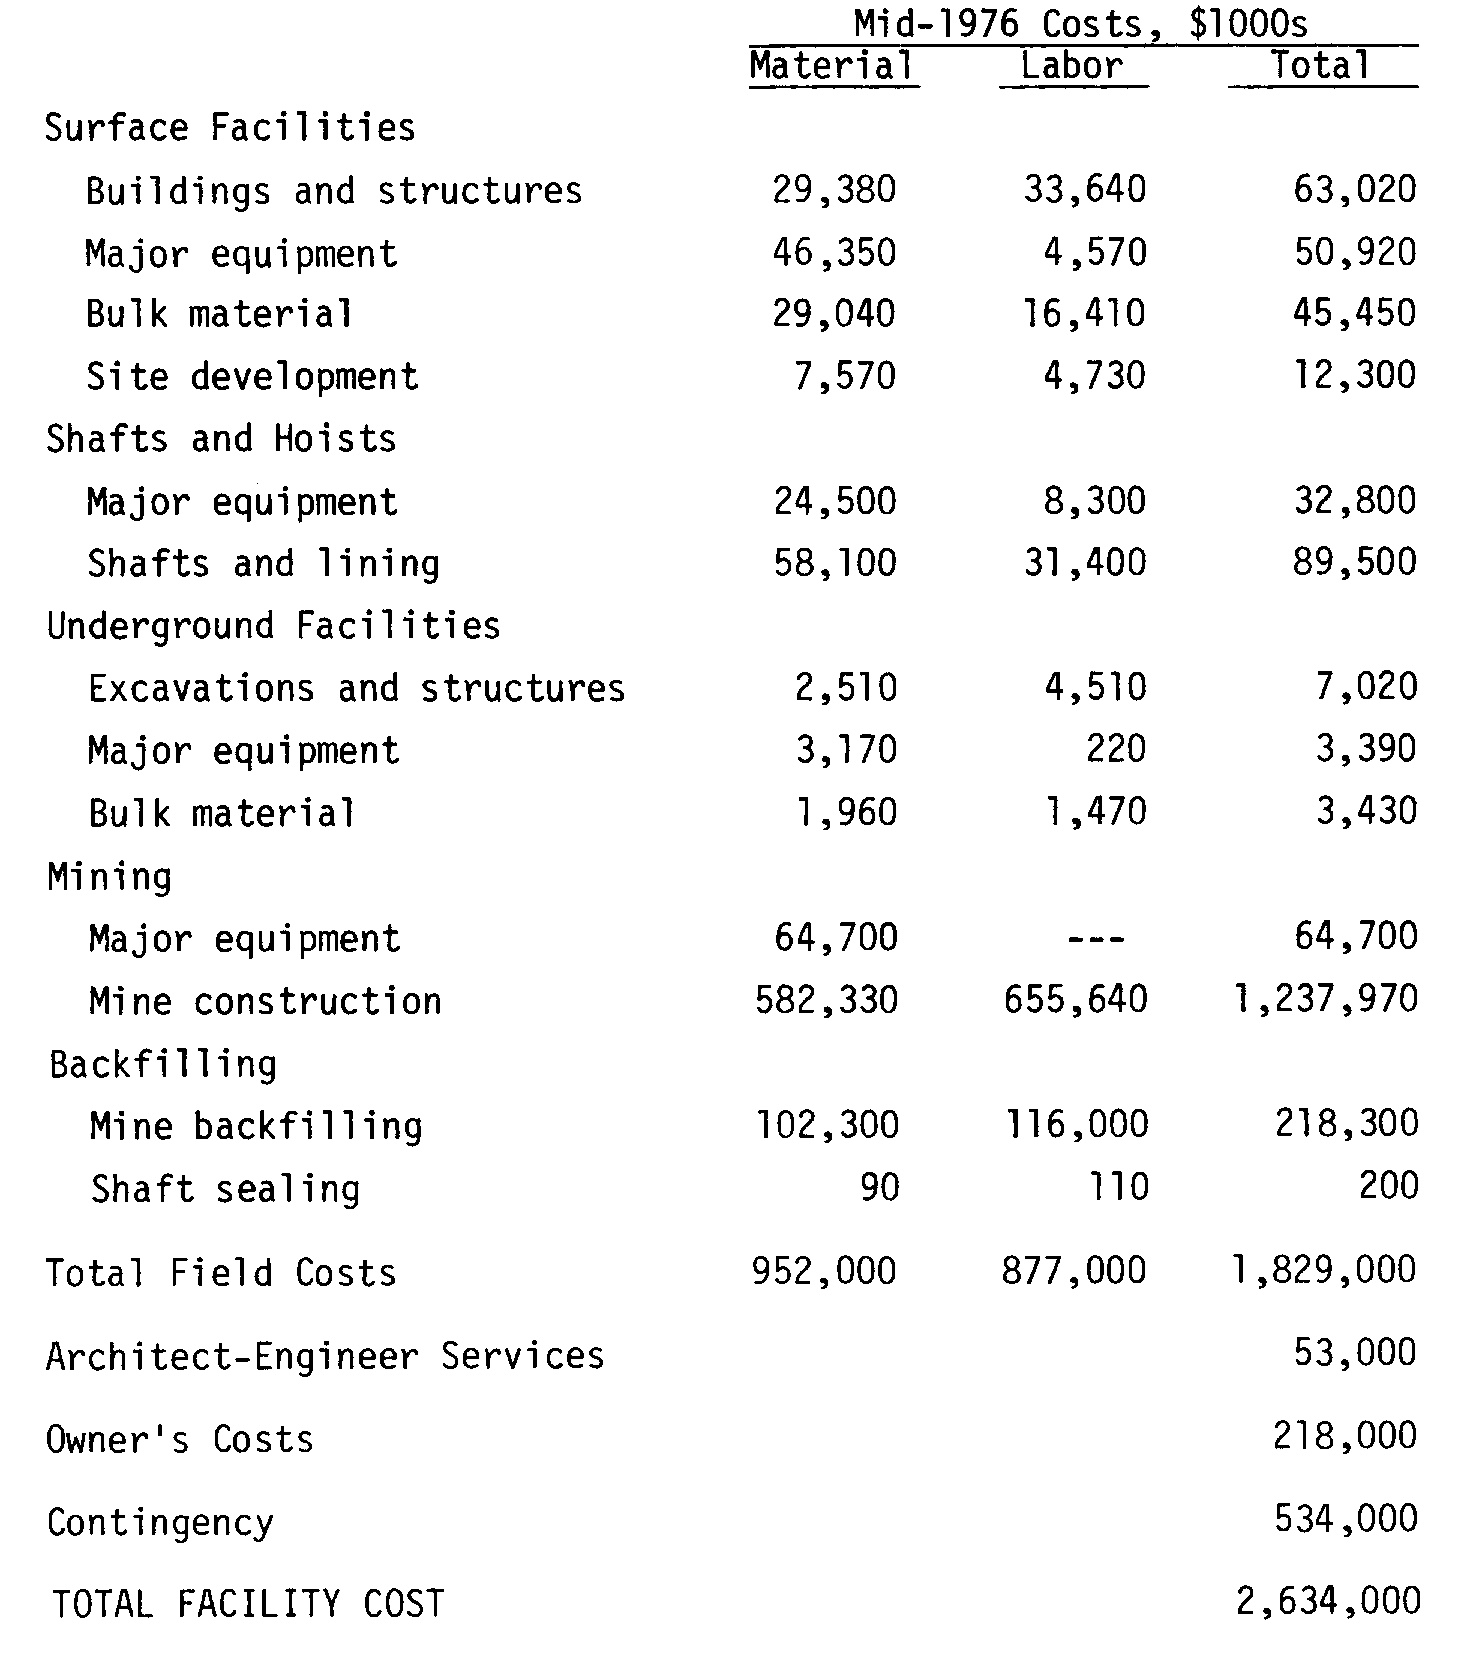


    Image #2:
    Origin: file:/home/alexander_jsl/Workspace/spark-ocr-workshop/jupyter/data/tab_images_hocr/cTDaR_t10011.jpg
    Resolution: 0 dpi
    Width: 816 px
    Height: 1056 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


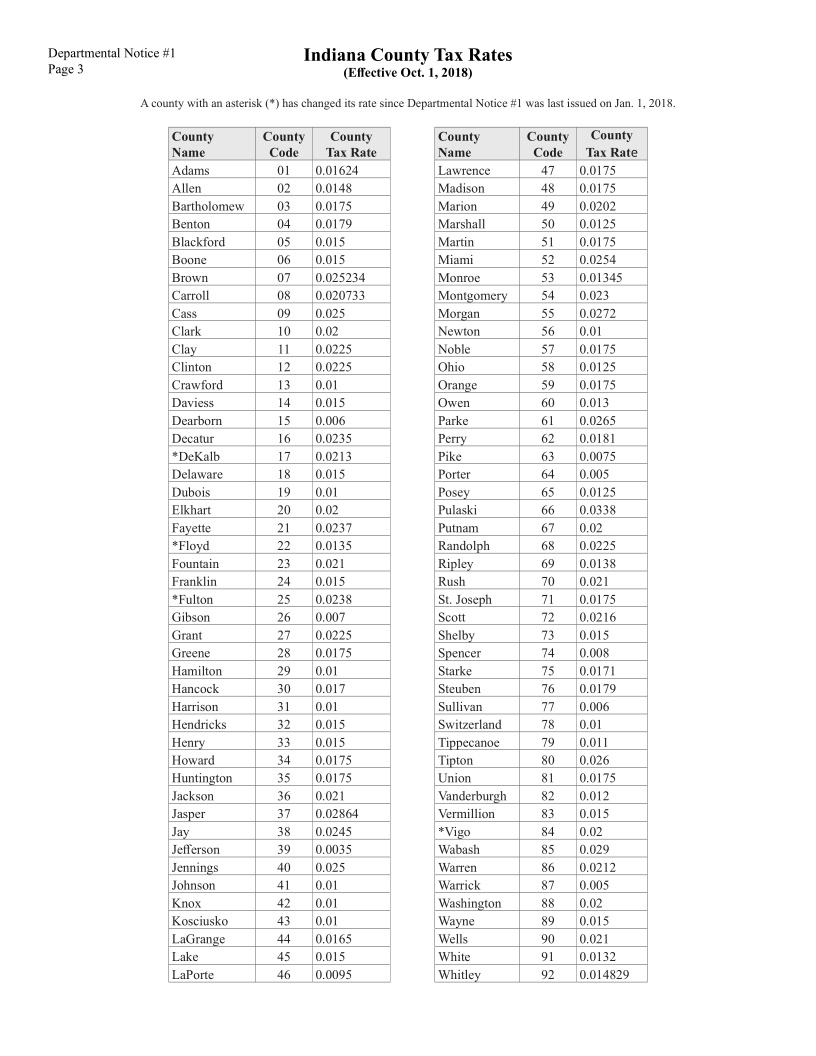

In [5]:
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_images, display_tables, display_table
from pyspark.ml import PipelineModel
import pyspark.sql.functions as f

image_df= spark.read.format("binaryFile").load(imagePath)

display_images(BinaryToImage().transform(image_df), "image")

## Define OCR Pipeline

In [6]:
binary_to_image = BinaryToImage()

table_detector = ImageTableDetector.pretrained("general_model_table_detection_v2", "en", "clinical/ocr")
table_detector.setInputCol("image")
table_detector.setOutputCol("table_regions")

splitter = ImageSplitRegions()
splitter.setInputCol("image")
splitter.setInputRegionsCol("table_regions")
splitter.setOutputCol("table_image")
splitter.setDropCols("image")
splitter.setImageType(ImageType.TYPE_BYTE_GRAY)

img_to_hocr = ImageToHocr()\
    .setInputCol("image")\
    .setOutputCol("hocr")\
    .setIgnoreResolution(False)\
    .setOcrParams(["preserve_interword_spaces=0"])

hocr_to_table = HocrToTextTable() \
        .setInputCol("hocr") \
        .setRegionCol("table_regions") \
        .setOutputCol("tables")

pipeline = PipelineModel(stages=[
    binary_to_image,
    table_detector,
    splitter,
    img_to_hocr,
    hocr_to_table
])

result = pipeline.transform(image_df).cache()
display(result)

general_model_table_detection_v2 download started this may take some time.
Approximate size to download 264.7 MB


table_image,image,pagenum,table_regions,modificationTime,path,length,hocr,tables,exception,table_index
{file:/home/alexa...,{file:/home/alexa...,0,"{0, 0, 94.0, 105....",2021-06-25 11:17:31,file:/home/alexan...,589958,<div class='ocr...,"{{0, 0, 0.0, 0.0,...",null,0
{file:/home/alexa...,{file:/home/alexa...,0,"{0, 0, 56.0, 4.0,...",2021-08-25 08:07:01,file:/home/alexan...,410439,<div class='ocr...,"{{0, 0, 0.0, 0.0,...",null,0
{file:/home/alexa...,{file:/home/alexa...,0,"{0, 0, 429.0, 120...",2021-06-25 11:17:31,file:/home/alexan...,206358,<div class='ocr...,"{{0, 0, 0.0, 0.0,...",null,0
{file:/home/alexa...,{file:/home/alexa...,0,"{1, 0, 165.0, 127...",2021-06-25 11:17:31,file:/home/alexan...,206358,<div class='ocr...,"{{0, 0, 0.0, 0.0,...",null,1
{file:/home/alexa...,{file:/home/alexa...,0,"{0, 0, 429.0, 120...",2021-06-25 11:17:31,file:/home/alexan...,206358,<div class='ocr...,"{{0, 0, 0.0, 0.0,...",null,0
{file:/home/alexa...,{file:/home/alexa...,0,"{1, 0, 165.0, 127...",2021-06-25 11:17:31,file:/home/alexan...,206358,<div class='ocr...,"{{0, 0, 0.0, 0.0,...",null,1


## Run pipeline and show images with tables


    Image #0:
    Origin: file:/home/alexander_jsl/Workspace/spark-ocr-workshop/jupyter/data/tab_images_hocr/cTDaR_t10168.jpg
    Resolution: 0 dpi
    Width: 419 px
    Height: 443 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


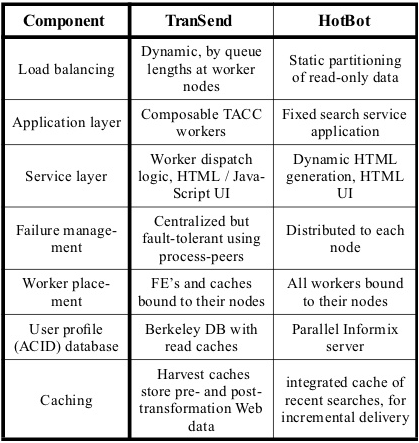


    Image #1:
    Origin: file:/home/alexander_jsl/Workspace/spark-ocr-workshop/jupyter/data/tab_images_hocr/table4.jpg
    Resolution: 0 dpi
    Width: 1384 px
    Height: 1647 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


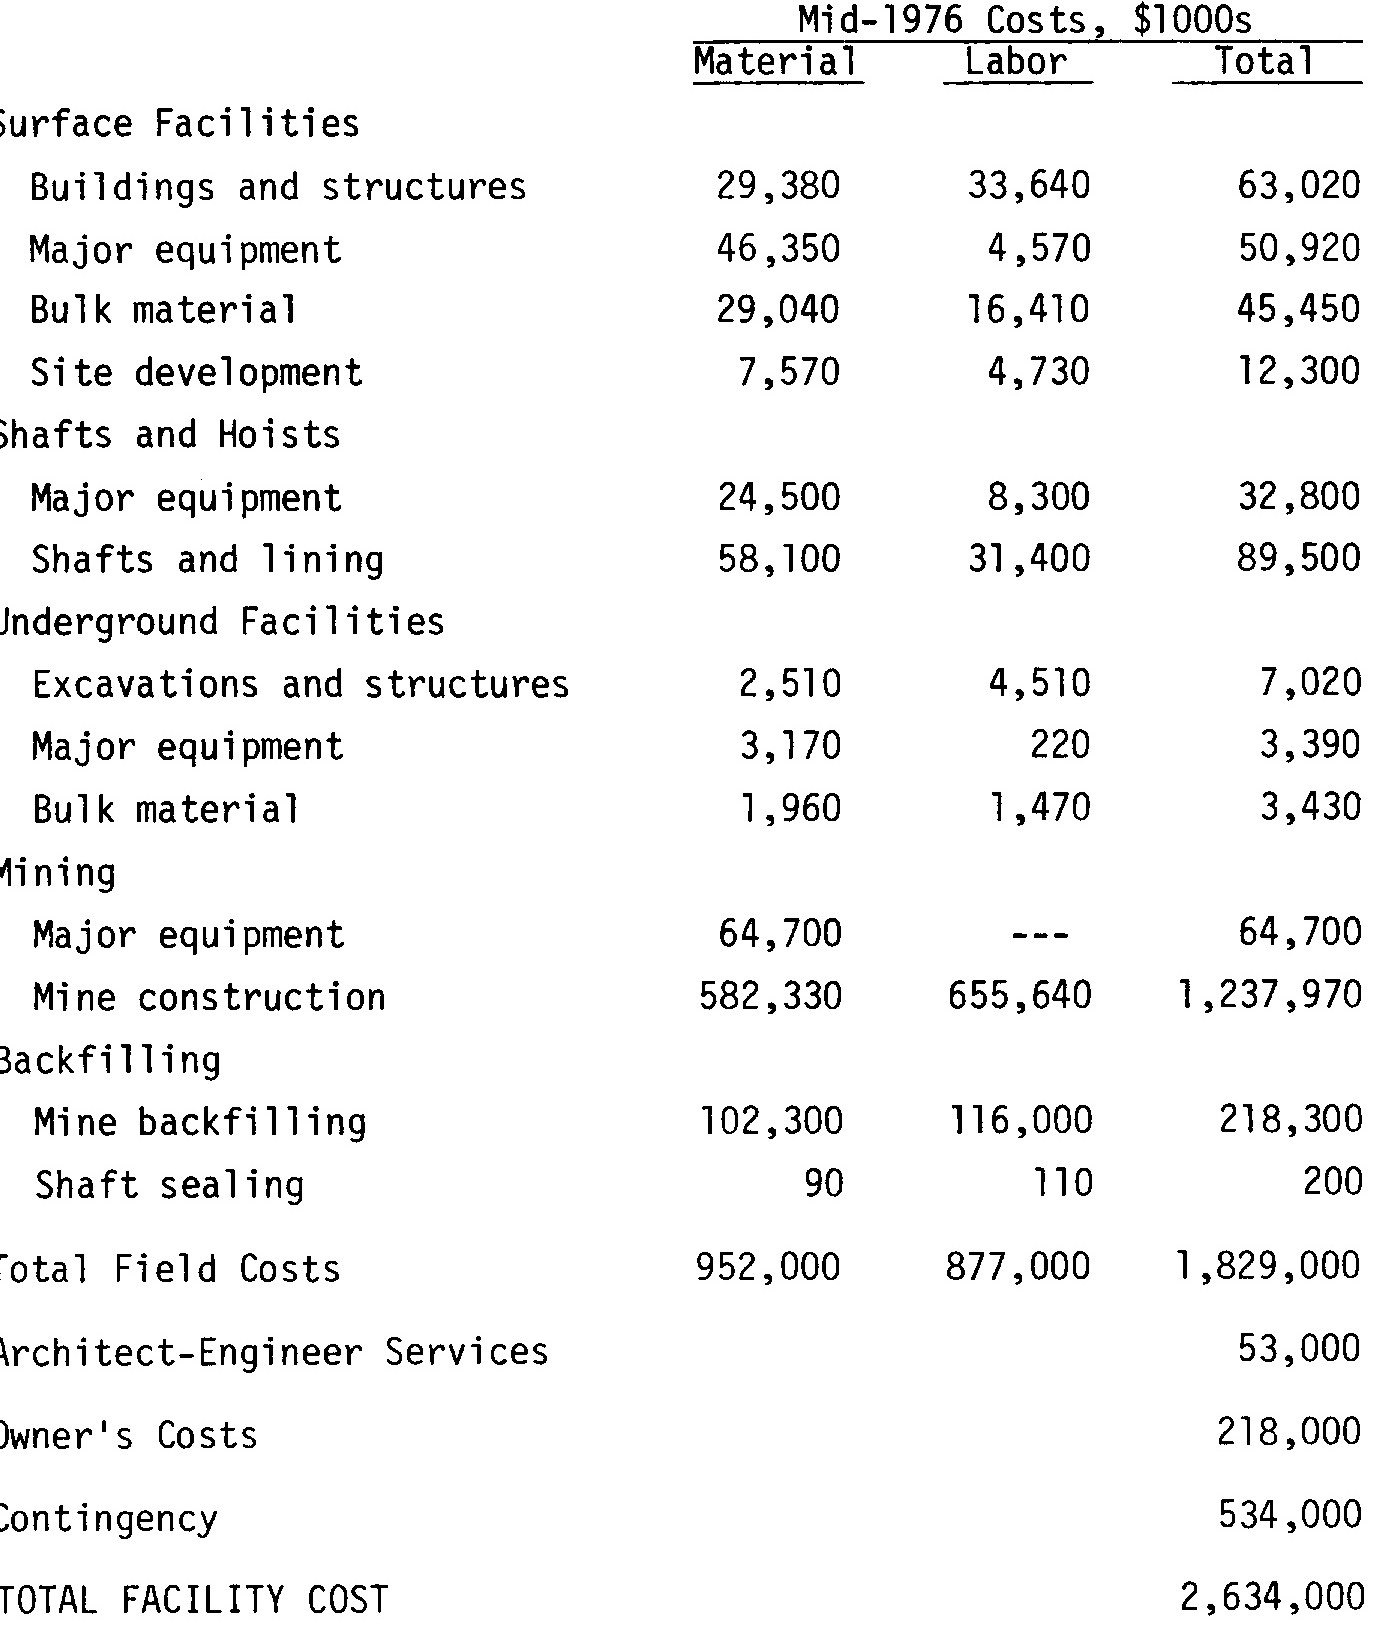


    Image #2:
    Origin: file:/home/alexander_jsl/Workspace/spark-ocr-workshop/jupyter/data/tab_images_hocr/cTDaR_t10011.jpg
    Resolution: 0 dpi
    Width: 222 px
    Height: 872 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


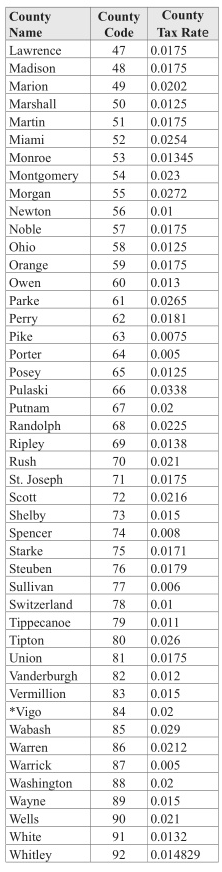


    Image #3:
    Origin: file:/home/alexander_jsl/Workspace/spark-ocr-workshop/jupyter/data/tab_images_hocr/cTDaR_t10011.jpg
    Resolution: 0 dpi
    Width: 222 px
    Height: 872 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


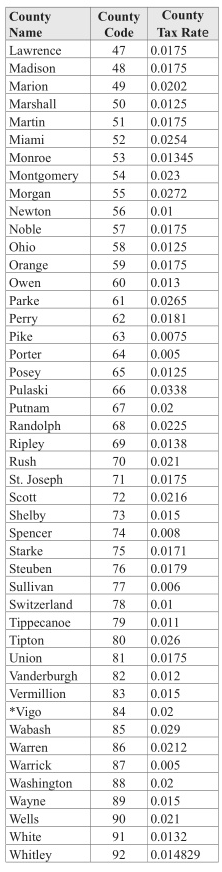


    Image #4:
    Origin: file:/home/alexander_jsl/Workspace/spark-ocr-workshop/jupyter/data/tab_images_hocr/cTDaR_t10011.jpg
    Resolution: 0 dpi
    Width: 229 px
    Height: 859 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


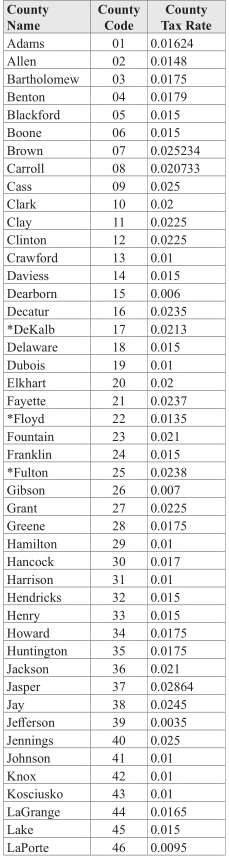

In [7]:
display_images(result, "table_image")

## Display recognized tables

In [8]:
display_tables(result, table_col = "tables", table_index_col = "table_index")

Filename: cTDaR_t10011.jpg
Page:     0
Table:    0
5


,col0,col1,col2,col3,col4
0,Departmental Notice #1,Indiana,,,
1,Page 3,(Effective Oct. A county with an asterisk (*) ...,None,None,None
2,‘County,‘County |,County,None,None
3,‘Name,‘Code,Tax Rate,None,None
4,Lawrence,47,0.0175,None,None
5,Madison,48,0.0175,None,None
6,Marion,49,"0.0202,",None,None
7,Marion Marshall,50,[0.0125,None,None
8,Martin,510.0175,None,None,None
9,Miami,510.0175 520.0254,None,None,None


Filename: cTDaR_t10168.jpg
Page:     0
Table:    0
11


,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10
0,Tad,,,,,,,,,,
1,"Dynamic, by queue",Static partitioning,None,None,None,None,None,None,None,None,None
2,lengths at worker,Static of read-only partitioning data,None,None,None,None,None,None,None,None,None
3,of read-only data,None,None,None,None,None,None,None,None,None,None
4,nodes,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...
56,performance,trace,playback,engine.,The,engine,can,generate,None,None,None
57,requests,at,a,constant,(and,dynamically,tunable),"rate,",or,it,can
58,faithfully play back a trace according to the ...,None,None,None,None,None,None,None,None,None,None
59,file.,We,thus,had,fine-grained,control,over both,the,amount,and,None


Filename: table4.jpg
Page:     0
Table:    0
3


,col0,col1,col2
0,Mid-1976,"Costs,",$1000s
1,Material,Labor,Total
2,Surface,Facilities,None
3,"29,380","33,640","63,020"
4,",350","4,570","50,920"
5,"29,040","16,410","45,450"
6,"7,570","4,730","12,300"
7,Shafts,and,Hoists
8,"24,500","8,300",",800"
9,"58,100","31,400","89,500"


Filename: cTDaR_t10011.jpg
Page:     0
Table:    1
4


,col0,col1,col2,col3
0,Departmental Notice,Tax Rates,,
1,Page 3,"Oct. 1, 2018)",None,None
2,A,Notice #1 was last issued on Jan.,"1, 2018.",None
3,‘County.,‘County |,County,None
4,Name,Code,‘Tax Rate,None
...,...,...,...,...
95,Johnson.,AL,0.01,None
96,Knox.,42,0.01,None
97,Kosciusko,43,0.01,None
98,LaGrange Kosciusko,440.0165 0.01,None,None
